In [88]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Image
import warnings
import seaborn as sns

%matplotlib inline

warnings.filterwarnings('ignore')
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 19}

plt.rc('font', **font)

In [5]:
#run_query(q): Takes a SQL query as an argument and returns a pandas dataframe by using the connection as a SQLite built-in context manager. 
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql_query(q, conn)
    
#run_command(c): Takes a SQL command as an argument and executes it using the sqlite module.
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
    
#show_tables(): calls the run_query() function to return a list of all tables and views in the database.
def show_tables():
    q = '''SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

In [8]:
#Initial state of the database
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


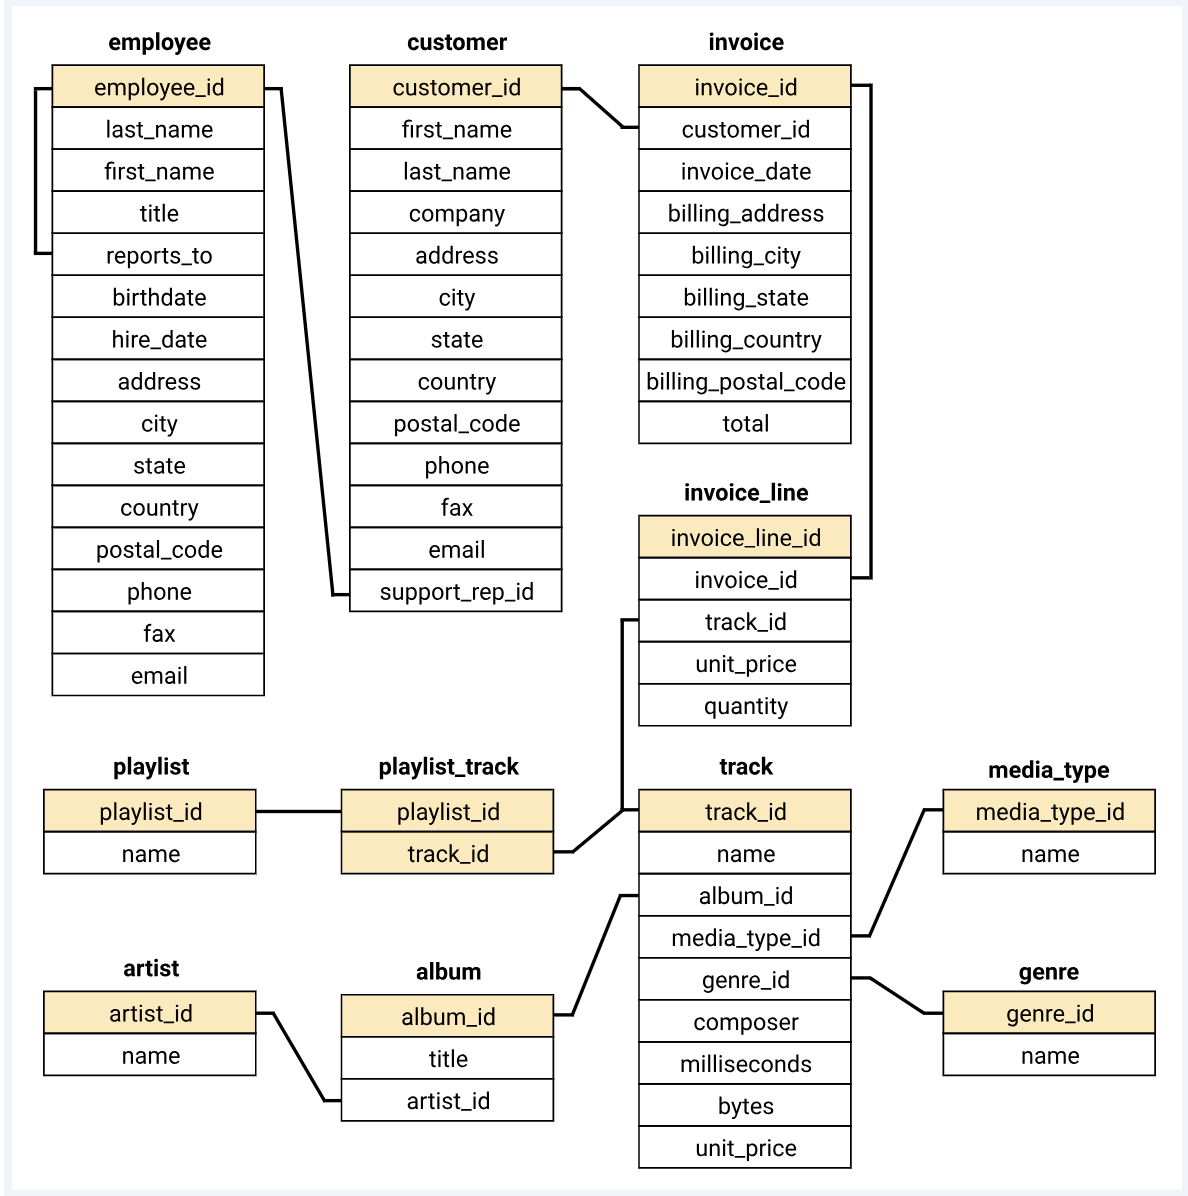

In [7]:
Image(filename='schema_diagram.png')

In [84]:
q1= '''
with gs as (
  select
    g.name as genre_name,
    sum(il.quantity) as tracks_sold
  from
    track t
    inner join genre g on g.genre_id = t.genre_id
    inner join invoice_line il on il.track_id = t.track_id
    inner join invoice i on i.invoice_id = il.invoice_id
    inner join customer c on c.customer_id = i.customer_id
  where
    c.country = "USA"
  group by
    g.name
  order by
    tracks_sold desc
)
select
  gs.genre_name as genre_name,
  gs.tracks_sold as tracks_sold,
  round(cast(gs.tracks_sold as float)/(SELECT SUM(tracks_sold) FROM gs),2) as percentage
from
  gs
group by genre_name
order by tracks_sold desc
limit 10
'''

In [86]:
data = run_query(q1)
data

,genre_name,tracks_sold,percentage
0,Rock,561,0.53
1,Alternative & Punk,130,0.12
2,Metal,124,0.12
3,R&B/Soul,53,0.05
4,Blues,36,0.03
5,Alternative,35,0.03
6,Pop,22,0.02
7,Latin,22,0.02
8,Hip Hop/Rap,20,0.02
9,Jazz,14,0.01


In [91]:
data=data.set_index('genre_name', drop=True)
data

,tracks_sold,percentage
genre_name,,
Rock,561,0.53
Alternative & Punk,130,0.12
Metal,124,0.12
R&B/Soul,53,0.05
Blues,36,0.03
Alternative,35,0.03
Pop,22,0.02
Latin,22,0.02
Hip Hop/Rap,20,0.02


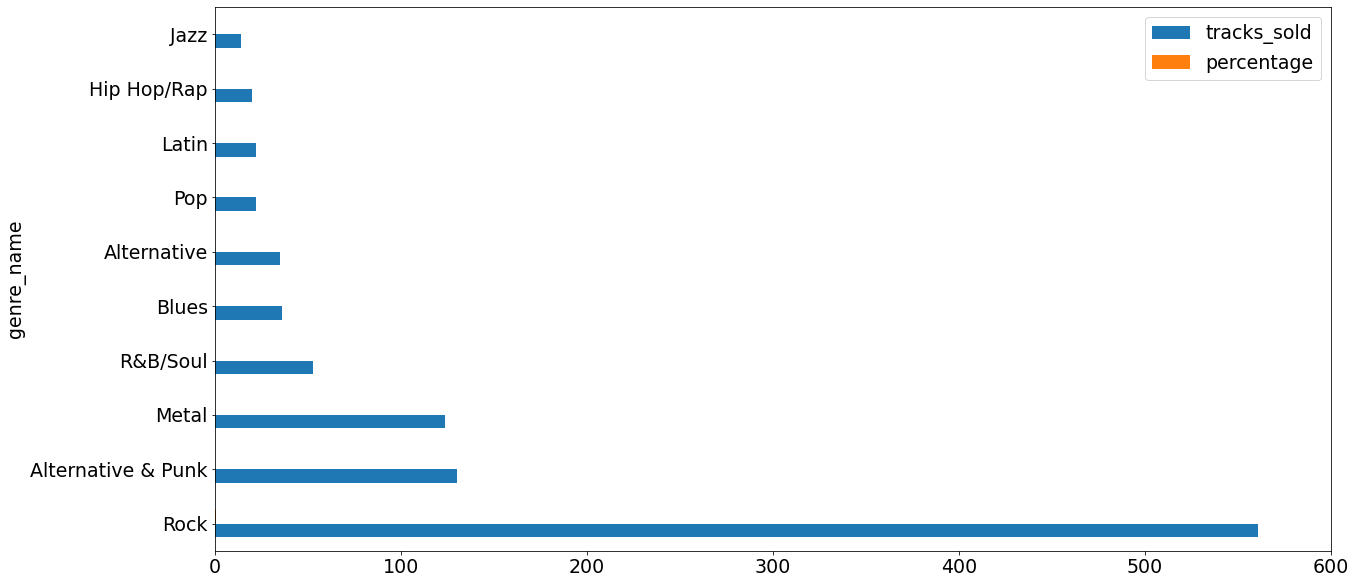

In [97]:
ax = data.plot.barh(xlim=(0,600), figsize=(20,10))

In [109]:
q2='''

select 
    e.employee_id as employee_id,
    sum(il.quantity*il.unit_price) as sales
  from
    track t
    inner join genre g on g.genre_id = t.genre_id
    inner join invoice_line il on il.track_id = t.track_id
    inner join invoice i on i.invoice_id = il.invoice_id
    inner join customer c on c.customer_id = i.customer_id
    inner join employee e on e.employee_id=c.support_rep_id
  group by
    e.employee_id
  order by
    sales desc

'''

In [112]:
sales_per_employee=run_query(q2)
sales_per_employee

,employee_id,sales
0,3,1731.51
1,4,1584.00
2,5,1393.92


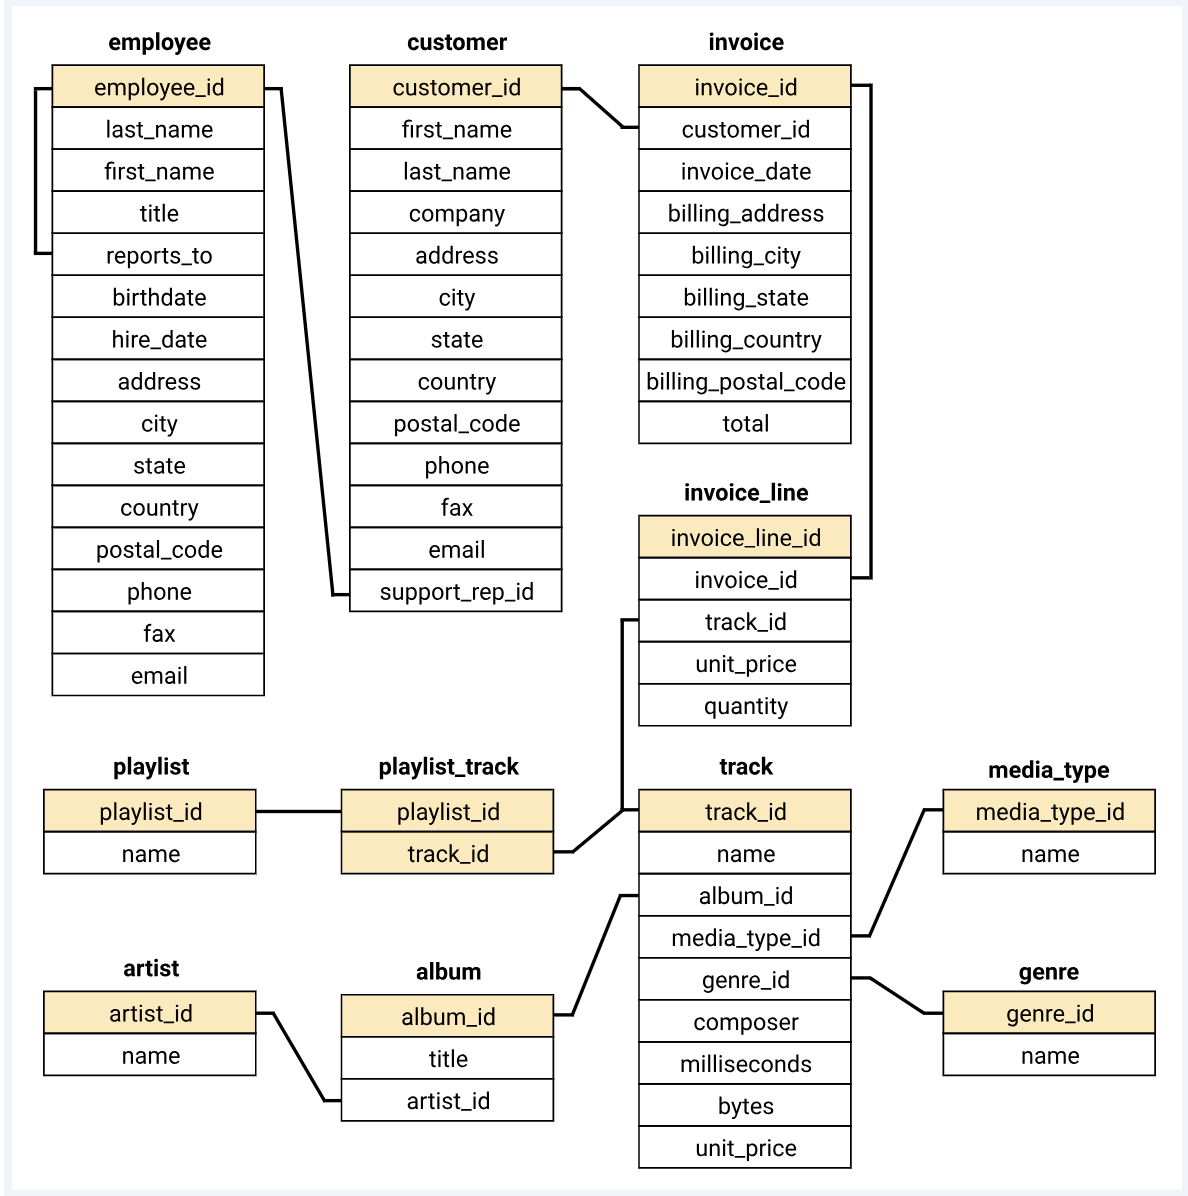

In [99]:
Image(filename='schema_diagram.png')

In [114]:
sales_per_employee

,employee_id,sales
0,3,1731.51
1,4,1584.00
2,5,1393.92


<AxesSubplot:ylabel='sales'>

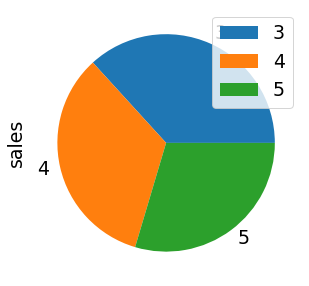

In [123]:
sales=sales_per_employee.set_index('employee_id',drop=True)
sales.plot.pie(y='sales', figsize=(10,5))

In [142]:
## number of customers per country, average sale value per customer per country, 
### total sales per country, average sale value per customer per country

q3='''
select 
c.country,
count(distinct c.customer_id) as number_customers,
round(sum(il.unit_price),0) as total_sales_per_country,
sum(il.unit_price)/count(distinct c.customer_id) as average_sale_price,
sum(il.quantity)/count(distinct c.customer_id) as average_order_value

from invoice_line il 
inner join invoice i on i.invoice_id = il.invoice_id
inner join customer c on c.customer_id=i.customer_id

group by c.country
having number_customers >1
order by number_customers desc

'''
run_query(q3)

,country,number_customers,total_sales_per_country,average_sale_price,average_order_value
0,USA,13,1040.0,80.037692,80
1,Canada,8,536.0,66.948750,67
2,France,5,389.0,77.814000,78
3,Brazil,5,428.0,85.536000,86
4,Germany,4,335.0,83.655000,84
5,United Kingdom,3,246.0,81.840000,82
6,Portugal,2,185.0,92.565000,93
7,India,2,183.0,91.575000,92
8,Czech Republic,2,273.0,136.620000,138


In [145]:
data=run_query(q3).set_index('country',drop=True)
data

,number_customers,total_sales_per_country,average_sale_price,average_order_value
country,,,,
USA,13,1040.0,80.037692,80
Canada,8,536.0,66.948750,67
France,5,389.0,77.814000,78
Brazil,5,428.0,85.536000,86
Germany,4,335.0,83.655000,84
United Kingdom,3,246.0,81.840000,82
Portugal,2,185.0,92.565000,93
India,2,183.0,91.575000,92
Czech Republic,2,273.0,136.620000,138


<AxesSubplot:xlabel='country'>

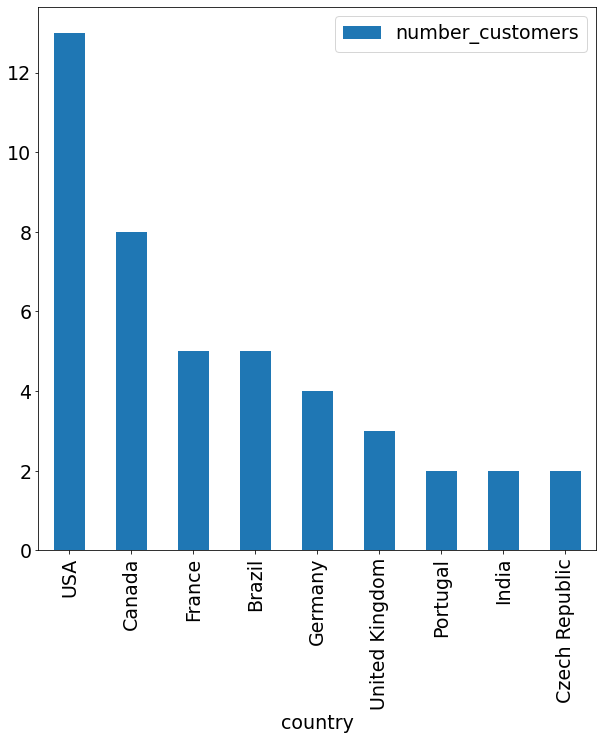

In [147]:
data.plot(y='number_customers',figsize=(10,10), kind='bar')

<AxesSubplot:xlabel='country'>

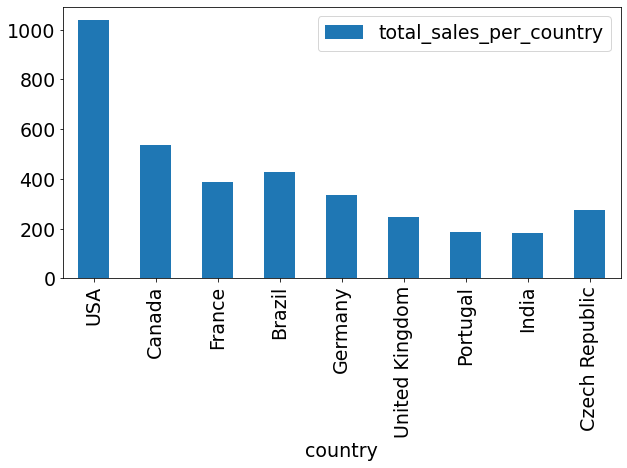

In [149]:
data.plot(y='total_sales_per_country',figsize=(10,5), kind='bar')